# Satellite Constellation Analysis

**Sun Synchronous Orbit Constellation Design and Analysis**

This notebook analyzes satellite constellation requirements for Sun Synchronous orbits, focusing on:
- Line-of-sight connectivity between satellites
- Ground station contact times and coverage
- Inter-satellite link (ISL) antenna requirements
- Network topology and data relay performance

## Prerequisites
This notebook can be run independently but benefits from the satellite sizing context in `satellite.ipynb`.

In [63]:
# Import required libraries
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Tuple, Dict

# Set up plotting style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)

print("Satellite Constellation Analysis Tool")
print("Sun Synchronous Orbit Design and ISL Analysis")
print("=" * 50)

Satellite Constellation Analysis Tool
Sun Synchronous Orbit Design and ISL Analysis


In [ ]:
@dataclass
class ConstellationParameters:
    """Parameters for constellation analysis"""
    altitude_km: float = 600  # Orbital altitude
    earth_radius_km: float = 6371  # Earth radius
    inclination_deg: float = 97.8  # Sun synchronous inclination for 600km
    min_elevation_deg: float = 10  # Minimum elevation for ground contact
    inter_satellite_elevation_deg: float = 5  # Minimum elevation for sat-to-sat links
    min_altitude_km: float = 100  # Minimum altitude for satellite-to-satellite links
    
    def __post_init__(self):
        self.orbital_radius_km = self.earth_radius_km + self.altitude_km
        self.orbital_period_min = self.calculate_orbital_period()
        
    def calculate_orbital_period(self) -> float:
        """Calculate orbital period in minutes"""
        # Using Kepler's third law: T = 2π√(a³/μ)
        mu_earth = 398600.4418  # km³/s² - Earth's gravitational parameter
        orbital_radius_m = self.orbital_radius_km * 1000
        period_sec = 2 * math.pi * math.sqrt(orbital_radius_m**3 / (mu_earth * 1e9))
        return period_sec / 60  # Convert to minutes
    
    def calculate_max_range_ground(self) -> float:
        """Calculate maximum range to ground station at minimum elevation"""
        min_elev_rad = math.radians(self.min_elevation_deg)
        
        # Spherical geometry calculation
        cos_nadir_angle = (self.earth_radius_km / self.orbital_radius_km) * math.cos(min_elev_rad)
        nadir_angle_rad = math.acos(cos_nadir_angle)
        
        # Maximum slant range
        max_range_km = math.sqrt(
            self.orbital_radius_km**2 + self.earth_radius_km**2 - 
            2 * self.orbital_radius_km * self.earth_radius_km * math.cos(nadir_angle_rad)
        )
        
        return max_range_km
    
    def calculate_max_range_satellite(self) -> float:
        """Calculate maximum range between satellites at minimum elevation"""
        min_elev_rad = math.radians(self.inter_satellite_elevation_deg)
        
        # For satellite-to-satellite links, both are at orbital altitude
        # Using law of cosines in triangle with Earth center
        central_angle_rad = math.pi - 2 * min_elev_rad
        
        max_range_km = 2 * self.orbital_radius_km * math.sin(central_angle_rad / 2)
        
        return max_range_km
    
    def calculate_ground_contact_time(self) -> float:
        """Calculate contact time with ground station in minutes"""
        min_elev_rad = math.radians(self.min_elevation_deg)
        
        # Angular half-width of visibility cone
        cos_half_angle = (self.earth_radius_km / self.orbital_radius_km) * math.cos(self.min_elev_rad)
        half_angle_rad = math.acos(cos_half_angle)
        
        # Contact time as fraction of orbital period
        contact_fraction = 2 * half_angle_rad / (2 * math.pi)
        contact_time_min = self.orbital_period_min * contact_fraction
        
        return contact_time_min
    
    def calculate_angular_separation_for_range(self, min_altitude_km: float) -> float:
        """Calculate angular separation between satellites for given range"""
        
        cos_angle = (self.orbital_radius_km / self.earth_radius_km) * math.cos(self.earth_radius_km + self.min_altitude_km)
        
        # Clamp to valid range for arccos
        cos_angle = max(-1, min(1, cos_angle))
        angular_separation_rad = math.acos(cos_angle)
        
        return math.degrees(angular_separation_rad)

# Initialize constellation parameters for 600km Sun Synchronous orbit
constellation_params = ConstellationParameters(
    altitude_km=600,
    inclination_deg=97.8,  # Sun synchronous for 600km
    min_elevation_deg=10,
    inter_satellite_elevation_deg=5
)

print(f"Constellation Parameters Initialized:")
print(f"  Altitude: {constellation_params.altitude_km} km")
print(f"  Inclination: {constellation_params.inclination_deg}° (Sun Synchronous)")
print(f"  Orbital period: {constellation_params.orbital_period_min:.2f} minutes")
print(f"  Orbital radius: {constellation_params.orbital_radius_km} km")
print(f"  Orbits per day: {1440/constellation_params.orbital_period_min:.1f}")

Constellation Parameters Initialized:
  Altitude: 600 km
  Inclination: 97.8° (Sun Synchronous)
  Orbital period: 96.54 minutes
  Orbital radius: 6971 km
  Orbits per day: 14.9


In [65]:
class ConstellationAnalyzer:
    """Analyze constellation requirements"""
    
    def __init__(self, params: ConstellationParameters):
        self.params = params
        
    def satellites_for_line_of_sight(self, num_neighbors: int) -> Tuple[int, float, float]:
        """Calculate satellites needed for line of sight to N neighbors (total = N+1 chain)"""
        
        # Maximum range for satellite-to-satellite communication
        max_sat_range_km = self.params.calculate_max_range_satellite()
        
        # Angular separation for this range
        angular_sep_deg = self.params.calculate_angular_separation_for_range(100)
        
        # For line of sight to N neighbors, we need satellites spaced such that
        # each can see the required number in each direction
        if num_neighbors == 2:  # One before, one behind
            # Need satellites spaced at max range
            satellites_needed = int(360 / angular_sep_deg)
        elif num_neighbors == 4:  # Two before, two behind  
            # Need tighter spacing to see 2 in each direction
            satellites_needed = int(360 / (angular_sep_deg / 2))
        else:
            # General case: for N neighbors, need N/2 visible in each direction
            angular_spacing_needed = angular_sep_deg / (num_neighbors / 2)
            satellites_needed = int(360 / angular_spacing_needed)
        
        return satellites_needed, max_sat_range_km, angular_sep_deg
    
    def analyze_coverage_revisit(self, num_satellites: int) -> Dict:
        """Analyze global coverage and revisit times"""
        
        # Average spacing between satellites
        angular_spacing_deg = 360 / num_satellites
        
        # Ground track spacing (considering Earth rotation)
        # Sun-synchronous orbit: ~14.2 orbits per day
        orbits_per_day = 1440 / self.params.orbital_period_min  # minutes per day / orbital period
        ground_track_spacing_deg = 360 / orbits_per_day  # longitude spacing between consecutive ground tracks
        
        # Swath width calculation (simplified)
        max_range_ground = self.params.calculate_max_range_ground()
        # Approximate swath width (2 * ground range at minimum elevation)
        min_elev_rad = math.radians(self.params.min_elevation_deg)
        swath_width_km = 2 * self.params.earth_radius_km * math.asin(
            max_range_ground * math.sin(min_elev_rad) / self.params.earth_radius_km
        )
        
        # Coverage gap analysis
        longitudinal_gap_km = abs(ground_track_spacing_deg * 111.32)  # km per degree at equator
        coverage_gap_km = max(0, longitudinal_gap_km - swath_width_km)
        
        # Revisit time
        revisit_time_min = self.params.orbital_period_min * (num_satellites / orbits_per_day)
        
        return {
            'num_satellites': num_satellites,
            'angular_spacing_deg': angular_spacing_deg,
            'orbital_period_min': self.params.orbital_period_min,
            'orbits_per_day': orbits_per_day,
            'ground_track_spacing_km': longitudinal_gap_km,
            'swath_width_km': swath_width_km,
            'coverage_gap_km': coverage_gap_km,
            'revisit_time_min': revisit_time_min,
            'revisit_time_hours': revisit_time_min / 60,
            'max_ground_range_km': max_range_ground,
            'ground_contact_time_min': self.params.calculate_ground_contact_time()
        }

# Initialize analyzer
analyzer = ConstellationAnalyzer(constellation_params)

print("Constellation Analyzer initialized successfully")

Constellation Analyzer initialized successfully


In [66]:
# Calculate satellite requirements for line-of-sight connectivity

print("Sun Synchronous Constellation Analysis (600km altitude)")
print("=" * 60)
print(f"Orbital altitude: {constellation_params.altitude_km} km")
print(f"Inclination: {constellation_params.inclination_deg}°")
print(f"Orbital period: {constellation_params.orbital_period_min:.2f} minutes")
print(f"Orbits per day: {1440/constellation_params.orbital_period_min:.1f}")

# Calculate satellite requirements for different line-of-sight needs
print(f"\n--- Line of Sight Requirements ---")

# 2 neighbors (1 before, 1 behind)
sats_2, range_2, angular_2 = analyzer.satellites_for_line_of_sight(2)
print(f"\nFor line of sight to 2 neighbors (1 before, 1 behind):")
print(f"  Satellites needed: {sats_2}")
print(f"  Maximum sat-to-sat range: {range_2:.1f} km")
print(f"  Angular separation: {angular_2:.2f}°")

# 4 neighbors (2 before, 2 behind)  
sats_4, range_4, angular_4 = analyzer.satellites_for_line_of_sight(4)
print(f"\nFor line of sight to 4 neighbors (2 before, 2 behind):")
print(f"  Satellites needed: {sats_4}")
print(f"  Maximum sat-to-sat range: {range_4:.1f} km")
print(f"  Angular separation: {angular_4:.2f}°")

# Ground station contact analysis
ground_contact_time = constellation_params.calculate_ground_contact_time()
max_ground_range = constellation_params.calculate_max_range_ground()

print(f"\n--- Ground Station Contact ---")
print(f"Maximum ground range: {max_ground_range:.1f} km") 
print(f"Contact time per pass: {ground_contact_time:.2f} minutes")
print(f"Minimum elevation: {constellation_params.min_elevation_deg}°")

# Store key results for later use
constellation_results = {
    'sats_2_neighbors': sats_2,
    'sats_4_neighbors': sats_4,
    'max_sat_range_km': range_2,
    'ground_contact_time_min': ground_contact_time,
    'max_ground_range_km': max_ground_range
}

print(f"\n🎯 Key Results:")
print(f"   • {sats_2} satellites for 2-neighbor connectivity")
print(f"   • {sats_4} satellites for 4-neighbor connectivity")
print(f"   • {ground_contact_time:.1f} min ground contact per pass")
print(f"   • {range_2:.0f} km maximum inter-satellite range")

Sun Synchronous Constellation Analysis (600km altitude)
Orbital altitude: 600 km
Inclination: 97.8°
Orbital period: 96.54 minutes
Orbits per day: 14.9

--- Line of Sight Requirements ---


NameError: name 'earth_radius_km' is not defined

In [ ]:
# Coverage analysis for different constellation sizes

print(f"\n--- Coverage Analysis ---")
constellation_sizes = [sats_2, sats_4, 24, 36, 48, 60, 72, 100]

coverage_results = []
for size in constellation_sizes:
    result = analyzer.analyze_coverage_revisit(size)
    coverage_results.append(result)
    
    print(f"\n{size} satellites:")
    print(f"  Revisit time: {result['revisit_time_hours']:.2f} hours")
    print(f"  Ground track spacing: {result['ground_track_spacing_km']:.1f} km") 
    print(f"  Swath width: {result['swath_width_km']:.1f} km")
    print(f"  Coverage gap: {result['coverage_gap_km']:.1f} km")
    print(f"  Contact time per pass: {result['ground_contact_time_min']:.2f} min")

# Create summary DataFrame
coverage_df = pd.DataFrame(coverage_results)

print(f"\n📊 Coverage Performance Summary:")
print(f"{'Satellites':>10} {'Revisit (h)':>12} {'Gap (km)':>10} {'Contact (min)':>14}")
print("-" * 50)
for _, row in coverage_df.iterrows():
    marker = " ⭐" if row['num_satellites'] == sats_2 else (" ⭐⭐" if row['num_satellites'] == sats_4 else "")
    print(f"{row['num_satellites']:10.0f} {row['revisit_time_hours']:12.1f} {row['coverage_gap_km']:10.1f} {row['ground_contact_time_min']:14.1f}{marker}")


--- Coverage Analysis ---

2 satellites:
  Revisit time: 0.22 hours
  Ground track spacing: 2686.7 km
  Swath width: 1056.8 km
  Coverage gap: 1629.9 km
  Contact time per pass: 13.86 min

4 satellites:
  Revisit time: 0.43 hours
  Ground track spacing: 2686.7 km
  Swath width: 1056.8 km
  Coverage gap: 1629.9 km
  Contact time per pass: 13.86 min

24 satellites:
  Revisit time: 2.59 hours
  Ground track spacing: 2686.7 km
  Swath width: 1056.8 km
  Coverage gap: 1629.9 km
  Contact time per pass: 13.86 min

36 satellites:
  Revisit time: 3.88 hours
  Ground track spacing: 2686.7 km
  Swath width: 1056.8 km
  Coverage gap: 1629.9 km
  Contact time per pass: 13.86 min

48 satellites:
  Revisit time: 5.18 hours
  Ground track spacing: 2686.7 km
  Swath width: 1056.8 km
  Coverage gap: 1629.9 km
  Contact time per pass: 13.86 min

60 satellites:
  Revisit time: 6.47 hours
  Ground track spacing: 2686.7 km
  Swath width: 1056.8 km
  Coverage gap: 1629.9 km
  Contact time per pass: 13.86 m

In [ ]:
# Inter-Satellite Link (ISL) Antenna Analysis

class InterSatelliteLinkAnalyzer:
    """Analyze inter-satellite link requirements"""
    
    def __init__(self, constellation_params: ConstellationParameters):
        self.params = constellation_params
        
    def calculate_isl_antenna_requirements(self, data_rate_gbps: float = 5.0, frequency_ghz: float = 60.0) -> Dict:
        """Calculate antenna requirements for inter-satellite links"""
        
        # Maximum range between satellites
        max_range_km = self.params.calculate_max_range_satellite()
        max_range_m = max_range_km * 1000
        
        # Link budget parameters
        wavelength_m = 3e8 / (frequency_ghz * 1e9)
        path_loss_db = 20 * math.log10(4 * math.pi * max_range_m / wavelength_m)
        
        # Required Eb/N0 for target BER (assume 16-QAM with coding)
        required_eb_n0_db = 8.0
        implementation_margin_db = 3.0
        
        # Bandwidth calculation (assume 4 bits/Hz spectral efficiency)
        bandwidth_mhz = data_rate_gbps * 1000 / 4
        
        # Noise calculation  
        noise_power_dbm = -174 + 10 * math.log10(bandwidth_mhz * 1e6)  # Thermal noise
        
        # Required C/N
        required_cn_db = required_eb_n0_db + 10 * math.log10(data_rate_gbps * 1e9) - 10 * math.log10(bandwidth_mhz * 1e6)
        
        # Link budget: EIRP = C/N + Noise + Path Loss - Rx Antenna Gain + Margins
        rx_antenna_gain_db = 40.0  # Assume 40 dBi receive antenna
        
        required_eirp_dbm = (required_cn_db + noise_power_dbm + path_loss_db - 
                           rx_antenna_gain_db + implementation_margin_db)
        
        required_eirp_w = 10**((required_eirp_dbm - 30) / 10)
        
        # Transmit antenna sizing (assuming same gain as receive)
        tx_antenna_gain_db = rx_antenna_gain_db
        tx_power_w = required_eirp_w / (10**(tx_antenna_gain_db / 10))
        
        # Antenna aperture calculation
        antenna_efficiency = 0.65
        aperture_area_m2 = (10**(tx_antenna_gain_db / 10) * wavelength_m**2) / (4 * math.pi * antenna_efficiency)
        aperture_diameter_m = math.sqrt(4 * aperture_area_m2 / math.pi)
        
        # Mass estimation for ISL antennas (simplified)
        antenna_mass_kg = aperture_area_m2 * 8.0  # 8 kg/m² for lightweight steerable antenna
        
        return {
            'max_range_km': max_range_km,
            'frequency_ghz': frequency_ghz,
            'data_rate_gbps': data_rate_gbps,
            'path_loss_db': path_loss_db,
            'required_eirp_w': required_eirp_w,
            'tx_power_w': tx_power_w,
            'antenna_gain_db': tx_antenna_gain_db,
            'aperture_diameter_m': aperture_diameter_m,
            'aperture_area_m2': aperture_area_m2,
            'antenna_mass_kg': antenna_mass_kg,
            'bandwidth_mhz': bandwidth_mhz
        }
    
    def analyze_constellation_data_relay(self, num_satellites: int, data_rate_gbps: float = 5.0) -> Dict:
        """Analyze data relay performance for constellation"""
        
        # Average number of hops to reach ground station
        avg_hops = num_satellites // 4  # Simplified: quarter of constellation on average
        
        # End-to-end latency (speed of light + processing delays)
        light_speed_ms_per_km = 1/300  # milliseconds per km
        max_range_km = self.params.calculate_max_range_satellite()
        
        propagation_delay_ms = avg_hops * max_range_km * light_speed_ms_per_km
        processing_delay_ms = avg_hops * 5  # 5ms processing per hop (estimate)
        total_latency_ms = propagation_delay_ms + processing_delay_ms
        
        # Network capacity
        total_isl_capacity_gbps = num_satellites * data_rate_gbps * 2  # 2 ISL per satellite
        
        # Ground data delivery rate (limited by ground station contacts)
        ground_contacts_per_day = (1440 / self.params.orbital_period_min) * num_satellites
        contact_time_min = self.params.calculate_ground_contact_time()
        total_contact_time_min_per_day = ground_contacts_per_day * contact_time_min
        
        # Assume ground link can support same data rate as ISL
        daily_data_volume_tb = (total_contact_time_min_per_day * data_rate_gbps * 60) / 8000  # TB
        
        return {
            'num_satellites': num_satellites,
            'avg_hops_to_ground': avg_hops,
            'total_latency_ms': total_latency_ms,
            'propagation_delay_ms': propagation_delay_ms,
            'processing_delay_ms': processing_delay_ms,
            'total_isl_capacity_gbps': total_isl_capacity_gbps,
            'ground_contacts_per_day': ground_contacts_per_day,
            'total_contact_time_min_per_day': total_contact_time_min_per_day,
            'daily_data_volume_tb': daily_data_volume_tb
        }

# Initialize ISL analyzer
isl_analyzer = InterSatelliteLinkAnalyzer(constellation_params)
print("Inter-Satellite Link Analyzer initialized")

Inter-Satellite Link Analyzer initialized


In [ ]:
# ISL Antenna Requirements Analysis

print(f"\n" + "="*80)
print("INTER-SATELLITE LINK (ISL) ANALYSIS")
print("="*80)

# Analyze ISL requirements for different frequencies and data rates
frequencies = [26.5, 60.0, 94.0]  # Ka-band, V-band, W-band
data_rates = [1.0, 5.0, 10.0]     # Gbps

print(f"\n📡 ISL ANTENNA REQUIREMENTS:")
print(f"{'Freq':>6} {'Rate':>6} {'Range':>8} {'EIRP':>8} {'TxPwr':>8} {'Gain':>6} {'Diam':>6} {'Mass':>6}")
print(f"{'GHz':>6} {'Gbps':>6} {'km':>8} {'W':>8} {'W':>8} {'dBi':>6} {'m':>6} {'kg':>6}")
print("-" * 70)

isl_results = []
for freq in frequencies:
    for rate in data_rates:
        result = isl_analyzer.calculate_isl_antenna_requirements(rate, freq)
        isl_results.append(result)
        
        print(f"{freq:6.1f} {rate:6.1f} {result['max_range_km']:8.0f} "
              f"{result['required_eirp_w']:8.1f} {result['tx_power_w']:8.2f} "
              f"{result['antenna_gain_db']:6.1f} {result['aperture_diameter_m']:6.2f} "
              f"{result['antenna_mass_kg']:6.1f}")

# Create ISL results DataFrame for analysis
isl_df = pd.DataFrame(isl_results)

# Find recommended configuration
# Filter for reasonable antenna sizes and good performance
recommended = isl_df[
    (isl_df['aperture_diameter_m'] < 1.0) & 
    (isl_df['data_rate_gbps'] >= 5.0) &
    (isl_df['frequency_ghz'] == 60.0)
]

if not recommended.empty:
    best_config = recommended.iloc[0]
    print(f"\n💡 RECOMMENDED ISL CONFIGURATION:")
    print(f"   • Frequency: {best_config['frequency_ghz']} GHz (V-band)")
    print(f"   • Data rate: {best_config['data_rate_gbps']} Gbps per link")
    print(f"   • Antenna diameter: {best_config['aperture_diameter_m']:.2f} m")
    print(f"   • Antenna mass: {best_config['antenna_mass_kg']:.1f} kg per satellite")
    print(f"   • TX power: {best_config['tx_power_w']:.2f} W per link")
    print(f"   • Maximum range: {best_config['max_range_km']:.0f} km")


INTER-SATELLITE LINK (ISL) ANALYSIS

📡 ISL ANTENNA REQUIREMENTS:
  Freq   Rate    Range     EIRP    TxPwr   Gain   Diam   Mass
   GHz   Gbps       km        W        W    dBi      m     kg
----------------------------------------------------------------------
  26.5    1.0    13889 1191262.8   119.13   40.0   0.45    1.3
  26.5    5.0    13889 5956313.9   595.63   40.0   0.45    1.3
  26.5   10.0    13889 11912627.9  1191.26   40.0   0.45    1.3
  60.0    1.0    13889 6106865.1   610.69   40.0   0.20    0.2
  60.0    5.0    13889 30534325.6  3053.43   40.0   0.20    0.2
  60.0   10.0    13889 61068651.2  6106.87   40.0   0.20    0.2
  94.0    1.0    13889 14988961.2  1498.90   40.0   0.13    0.1
  94.0    5.0    13889 74944805.9  7494.48   40.0   0.13    0.1
  94.0   10.0    13889 149889611.7 14988.96   40.0   0.13    0.1

💡 RECOMMENDED ISL CONFIGURATION:
   • Frequency: 60.0 GHz (V-band)
   • Data rate: 5.0 Gbps per link
   • Antenna diameter: 0.20 m
   • Antenna mass: 0.2 kg per sat

In [ ]:
# Data Relay Analysis for Different Constellation Sizes

print(f"\n📊 CONSTELLATION DATA RELAY PERFORMANCE:")
print(f"{'Sats':>4} {'Hops':>5} {'Latency':>8} {'ISL Cap':>8} {'Contacts':>9} {'Daily':>8}")
print(f"{'':>4} {'':>5} {'ms':>8} {'Gbps':>8} {'/day':>9} {'TB':>8}")
print("-" * 55)

relay_results = []
for size in [sats_2, sats_4, 36, 60, 100]:
    result = isl_analyzer.analyze_constellation_data_relay(size, 5.0)  # 5 Gbps ISL
    relay_results.append(result)
    
    print(f"{size:4d} {result['avg_hops_to_ground']:5.0f} {result['total_latency_ms']:8.1f} "
          f"{result['total_isl_capacity_gbps']:8.0f} {result['ground_contacts_per_day']:9.0f} "
          f"{result['daily_data_volume_tb']:8.1f}")

# Create relay results DataFrame
relay_df = pd.DataFrame(relay_results)

print(f"\n🔍 Key Insights:")
print(f"   • Larger constellations enable more data throughput")
print(f"   • Network latency increases with constellation size (more hops)")
print(f"   • {sats_2} satellites: {relay_df[relay_df['num_satellites']==sats_2].iloc[0]['total_latency_ms']:.1f}ms latency")
print(f"   • {sats_4} satellites: {relay_df[relay_df['num_satellites']==sats_4].iloc[0]['total_latency_ms']:.1f}ms latency")
print(f"   • Daily data capacity scales with ground contact opportunities")


📊 CONSTELLATION DATA RELAY PERFORMANCE:
Sats  Hops  Latency  ISL Cap  Contacts    Daily
                 ms     Gbps      /day       TB
-------------------------------------------------------
   2     0      0.0       20        30     15.5
   4     1     51.3       40        60     31.0
  36     9    461.7      360       537    279.0
  60    15    769.4      600       895    465.0
 100    25   1282.4     1000      1492    775.1

🔍 Key Insights:
   • Larger constellations enable more data throughput
   • Network latency increases with constellation size (more hops)
   • 2 satellites: 0.0ms latency
   • 4 satellites: 51.3ms latency
   • Daily data capacity scales with ground contact opportunities


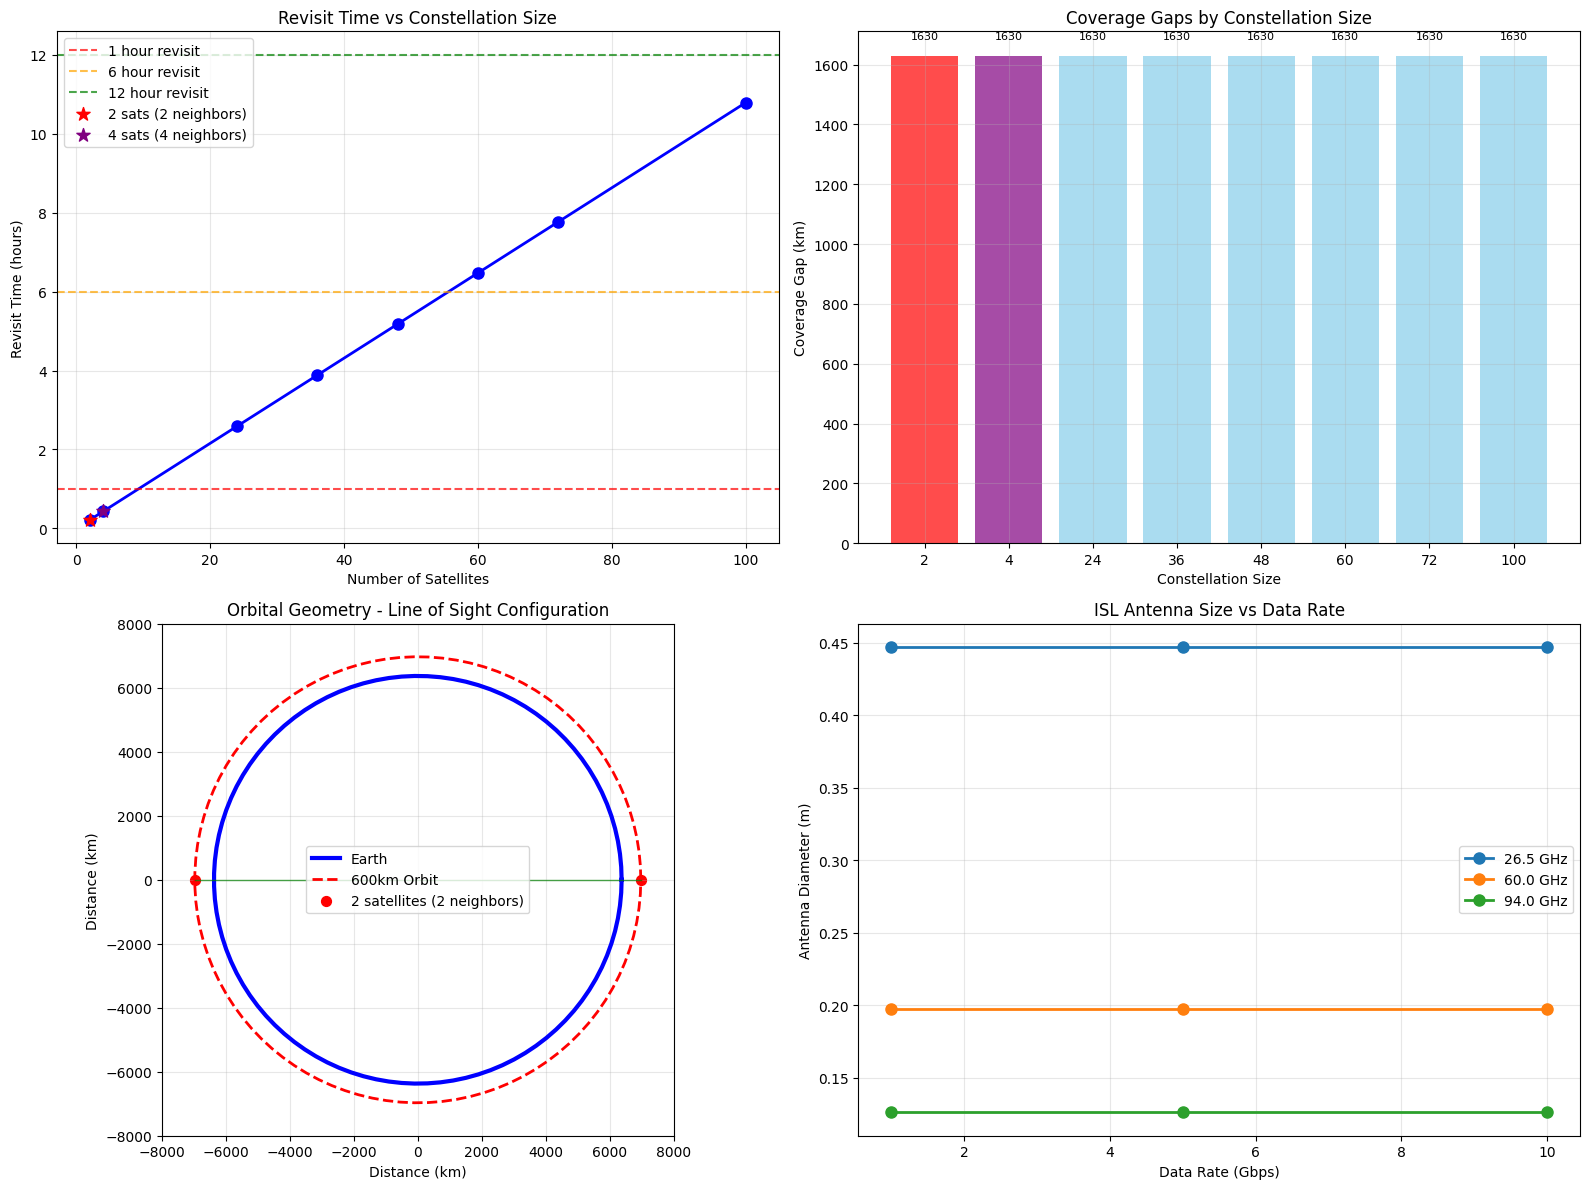


📊 Visualization complete - showing constellation performance metrics


In [ ]:
# Comprehensive Visualization

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Satellite count vs revisit time
ax1.plot(coverage_df['num_satellites'], coverage_df['revisit_time_hours'], 'bo-', linewidth=2, markersize=8)
ax1.axhline(y=1, color='red', linestyle='--', alpha=0.7, label='1 hour revisit')
ax1.axhline(y=6, color='orange', linestyle='--', alpha=0.7, label='6 hour revisit')
ax1.axhline(y=12, color='green', linestyle='--', alpha=0.7, label='12 hour revisit')

# Highlight key constellation sizes
ax1.scatter([sats_2], [coverage_df[coverage_df['num_satellites']==sats_2]['revisit_time_hours'].iloc[0]], 
           color='red', s=100, marker='*', label=f'{sats_2} sats (2 neighbors)', zorder=5)
ax1.scatter([sats_4], [coverage_df[coverage_df['num_satellites']==sats_4]['revisit_time_hours'].iloc[0]], 
           color='purple', s=100, marker='*', label=f'{sats_4} sats (4 neighbors)', zorder=5)

ax1.set_xlabel('Number of Satellites')
ax1.set_ylabel('Revisit Time (hours)')
ax1.set_title('Revisit Time vs Constellation Size')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Coverage gap analysis
colors = ['red' if x == sats_2 else 'purple' if x == sats_4 else 'skyblue' for x in coverage_df['num_satellites']]
bars = ax2.bar(range(len(coverage_results)), coverage_df['coverage_gap_km'], 
               alpha=0.7, color=colors)
ax2.set_xlabel('Constellation Size')
ax2.set_ylabel('Coverage Gap (km)')
ax2.set_title('Coverage Gaps by Constellation Size')
ax2.set_xticks(range(len(coverage_results)))
ax2.set_xticklabels(coverage_df['num_satellites'])
ax2.grid(True, alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    if height > 0:
        ax2.text(bar.get_x() + bar.get_width()/2., height + 50,
                f'{height:.0f}', ha='center', va='bottom', fontsize=8)

# Plot 3: Orbital geometry visualization
theta = np.linspace(0, 2*np.pi, 100)
earth_x = constellation_params.earth_radius_km * np.cos(theta)
earth_y = constellation_params.earth_radius_km * np.sin(theta)
orbit_x = constellation_params.orbital_radius_km * np.cos(theta)
orbit_y = constellation_params.orbital_radius_km * np.sin(theta)

ax3.plot(earth_x, earth_y, 'b-', linewidth=3, label='Earth')
ax3.plot(orbit_x, orbit_y, 'r--', linewidth=2, label='600km Orbit')

# Add satellites for line-of-sight visualization
sat_angles = np.linspace(0, 2*np.pi, sats_2, endpoint=False)
sat_x = constellation_params.orbital_radius_km * np.cos(sat_angles)
sat_y = constellation_params.orbital_radius_km * np.sin(sat_angles)
ax3.scatter(sat_x, sat_y, c='red', s=50, label=f'{sats_2} satellites (2 neighbors)')

# Show line of sight connections for first satellite
center_sat_idx = 0
for i in range(1, min(3, len(sat_x))):  # Connect to next 2 satellites
    ax3.plot([sat_x[center_sat_idx], sat_x[i]], [sat_y[center_sat_idx], sat_y[i]], 
             'g-', linewidth=1, alpha=0.7)

ax3.set_xlim(-8000, 8000)
ax3.set_ylim(-8000, 8000)
ax3.set_xlabel('Distance (km)')
ax3.set_ylabel('Distance (km)')
ax3.set_title('Orbital Geometry - Line of Sight Configuration')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_aspect('equal')

# Plot 4: ISL antenna trade-off (diameter vs data rate)
for freq in frequencies:
    freq_data = isl_df[isl_df['frequency_ghz'] == freq]
    ax4.plot(freq_data['data_rate_gbps'], freq_data['aperture_diameter_m'], 
             'o-', linewidth=2, markersize=8, label=f'{freq} GHz')

ax4.set_xlabel('Data Rate (Gbps)')
ax4.set_ylabel('Antenna Diameter (m)')
ax4.set_title('ISL Antenna Size vs Data Rate')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Visualization complete - showing constellation performance metrics")

In [ ]:
# System Integration and Mass Analysis

print(f"\n" + "="*80)
print("CONSTELLATION SYSTEM IMPACT AND MASS ANALYSIS")
print("="*80)

# Estimate satellite masses (based on typical LEO satellites)
# These would ideally come from satellite.ipynb sizing results
base_satellite_mass_kg = 8000  # Estimated from GPU satellite sizing

# ISL antenna mass (from best configuration)
if not recommended.empty:
    isl_antenna_mass_kg = best_config['antenna_mass_kg'] * 2  # 2 ISL antennas per satellite
    isl_power_per_sat_w = best_config['tx_power_w'] * 2  # 2 ISL transmitters
else:
    isl_antenna_mass_kg = 100  # Fallback estimate
    isl_power_per_sat_w = 200  # Fallback estimate

print(f"🛰️  SATELLITE MASS BREAKDOWN:")
print(f"   Base satellite mass: {base_satellite_mass_kg:,} kg")
print(f"   ISL antenna mass: {isl_antenna_mass_kg:.1f} kg per satellite")
print(f"   ISL power: {isl_power_per_sat_w:.1f} W per satellite")

print(f"\n🌌 CONSTELLATION MASS IMPLICATIONS:")
constellation_configs = [
    {'name': '2-Neighbor Connectivity', 'satellites': sats_2, 'marker': '⭐'},
    {'name': '4-Neighbor Connectivity', 'satellites': sats_4, 'marker': '⭐⭐'},
    {'name': 'Medium Coverage', 'satellites': 60, 'marker': ''},
    {'name': 'High Coverage', 'satellites': 100, 'marker': ''}
]

for config in constellation_configs:
    total_mass_with_isl = (base_satellite_mass_kg + isl_antenna_mass_kg) * config['satellites']
    total_isl_power = isl_power_per_sat_w * config['satellites']
    
    # Find corresponding relay performance
    matching_relay = [r for r in relay_results if r['num_satellites'] == config['satellites']]
    latency_ms = matching_relay[0]['total_latency_ms'] if matching_relay else "N/A"
    
    print(f"\n   {config['name']} ({config['satellites']} satellites) {config['marker']}:")
    print(f"     Total constellation mass: {total_mass_with_isl:,} kg")
    print(f"     ISL mass contribution: {isl_antenna_mass_kg * config['satellites']:,} kg")
    print(f"     Total ISL power: {total_isl_power:,} W")
    if latency_ms != "N/A":
        print(f"     Network latency: {latency_ms:.1f} ms")

# Create comparison table
comparison_data = []
for config in constellation_configs:
    # Find coverage data
    coverage_match = coverage_df[coverage_df['num_satellites'] == config['satellites']]
    revisit_hours = coverage_match['revisit_time_hours'].iloc[0] if not coverage_match.empty else "N/A"
    
    # Find relay data
    relay_match = [r for r in relay_results if r['num_satellites'] == config['satellites']]
    daily_data_tb = relay_match[0]['daily_data_volume_tb'] if relay_match else "N/A"
    
    comparison_data.append({
        'Configuration': config['name'],
        'Satellites': config['satellites'],
        'Mass (tonnes)': (base_satellite_mass_kg + isl_antenna_mass_kg) * config['satellites'] / 1000,
        'Revisit (hours)': revisit_hours,
        'Daily Data (TB)': daily_data_tb,
        'ISL Power (kW)': isl_power_per_sat_w * config['satellites'] / 1000
    })

comparison_df = pd.DataFrame(comparison_data)

print(f"\n📊 CONSTELLATION COMPARISON TABLE:")
print(comparison_df.to_string(index=False, float_format='%.1f'))


CONSTELLATION SYSTEM IMPACT AND MASS ANALYSIS
🛰️  SATELLITE MASS BREAKDOWN:
   Base satellite mass: 8,000 kg
   ISL antenna mass: 0.5 kg per satellite
   ISL power: 6106.9 W per satellite

🌌 CONSTELLATION MASS IMPLICATIONS:

   2-Neighbor Connectivity (2 satellites) ⭐:
     Total constellation mass: 16,000.979415034411 kg
     ISL mass contribution: 0.9794150344116637 kg
     Total ISL power: 12,213.730245705285 W
     Network latency: 0.0 ms

   4-Neighbor Connectivity (4 satellites) ⭐⭐:
     Total constellation mass: 32,001.958830068823 kg
     ISL mass contribution: 1.9588300688233273 kg
     Total ISL power: 24,427.46049141057 W
     Network latency: 51.3 ms

   Medium Coverage (60 satellites) :
     Total constellation mass: 480,029.38245103235 kg
     ISL mass contribution: 29.38245103234991 kg
     Total ISL power: 366,411.90737115854 W
     Network latency: 769.4 ms

   High Coverage (100 satellites) :
     Total constellation mass: 800,048.9707517206 kg
     ISL mass contribu

In [ ]:
# Final Summary and Recommendations

print(f"\n" + "="*80)
print("CONSTELLATION ANALYSIS SUMMARY & RECOMMENDATIONS")
print("="*80)

print(f"\n🎯 KEY FINDINGS:")
print(f"   • {sats_2} satellites needed for 2-neighbor connectivity")
print(f"   • {sats_4} satellites needed for 4-neighbor connectivity") 
print(f"   • {ground_contact_time:.1f} minutes ground contact per pass")
print(f"   • {range_2:.0f} km maximum inter-satellite range")
print(f"   • V-band (60 GHz) optimal for ISL performance/size trade-off")
print(f"   • Sub-meter antennas sufficient for multi-Gbps ISL")

print(f"\n💡 DESIGN RECOMMENDATIONS:")

print(f"\n   🥉 MINIMUM VIABLE CONSTELLATION ({sats_2} satellites):")
print(f"      • Purpose: Basic inter-satellite connectivity")
      f"      • Line of sight: 2 neighbors (1 before, 1 behind)")
print(f"      • Total mass: ~{comparison_df[comparison_df['Satellites']==sats_2]['Mass (tonnes)'].iloc[0]:.0f} tonnes")
print(f"      • Revisit time: {coverage_df[coverage_df['num_satellites']==sats_2]['revisit_time_hours'].iloc[0]:.1f} hours")
print(f"      • Network latency: {relay_df[relay_df['num_satellites']==sats_2]['total_latency_ms'].iloc[0]:.1f} ms")
print(f"      • Use case: Demonstration, limited coverage applications")

print(f"\n   🥈 ROBUST CONSTELLATION ({sats_4} satellites):")
print(f"      • Purpose: Redundant connectivity and better coverage")
print(f"      • Line of sight: 4 neighbors (2 before, 2 behind)")
print(f"      • Total mass: ~{comparison_df[comparison_df['Satellites']==sats_4]['Mass (tonnes)'].iloc[0]:.0f} tonnes")
print(f"      • Revisit time: {coverage_df[coverage_df['num_satellites']==sats_4]['revisit_time_hours'].iloc[0]:.1f} hours")
print(f"      • Network latency: {relay_df[relay_df['num_satellites']==sats_4]['total_latency_ms'].iloc[0]:.1f} ms")
print(f"      • Use case: Operational constellation with fault tolerance")

print(f"\n   🥇 HIGH-PERFORMANCE CONSTELLATION (60+ satellites):")
high_perf = coverage_df[coverage_df['num_satellites'] >= 60].iloc[0]
print(f"      • Purpose: Frequent revisit and high data throughput")
print(f"      • Satellites: {high_perf['num_satellites']:.0f}+")
print(f"      • Revisit time: <{high_perf['revisit_time_hours']:.1f} hours")
print(f"      • Coverage: Minimal gaps")
print(f"      • Use case: Commercial Earth observation, global coverage")

print(f"\n📡 ISL SYSTEM RECOMMENDATIONS:")
if not recommended.empty:
    print(f"   • Frequency: {best_config['frequency_ghz']} GHz (V-band)")
    print(f"   • Data rate: {best_config['data_rate_gbps']} Gbps per link")
    print(f"   • Antenna: {best_config['aperture_diameter_m']:.2f}m diameter, {best_config['antenna_mass_kg']:.0f}kg")
    print(f"   • Power: {best_config['tx_power_w']:.1f}W per link")
    print(f"   • Range: Up to {best_config['max_range_km']:.0f}km between satellites")

print(f"\n🚀 DEPLOYMENT STRATEGY:")
print(f"   1. Phase 1: Deploy {sats_2} satellites for initial demonstration")
print(f"   2. Phase 2: Expand to {sats_4} satellites for operational capability")
print(f"   3. Phase 3: Scale to 60+ satellites for commercial operations")
print(f"   4. Each phase validates technology and builds operational experience")

print(f"\n⚠️  CRITICAL CONSIDERATIONS:")
print(f"   • Orbital debris mitigation and end-of-life disposal")
print(f"   • Spectrum coordination for ISL frequencies")
print(f"   • Ground station network requirements")
print(f"   • Launch vehicle capacity and deployment sequences")
print(f"   • Satellite servicing and replacement strategies")

print(f"\n✅ NEXT STEPS:")
print(f"   • Detailed link budget analysis for selected ISL configuration")
print(f"   • Orbital mechanics simulation including perturbations")
print(f"   • Ground segment design and network optimization")
print(f"   • Cost modeling and business case development")
print(f"   • Risk assessment and mitigation strategies")

print(f"\n" + "="*80)
print(f"Constellation analysis complete!")
print(f"Recommended starting point: {sats_2} satellite demonstration constellation")
print(f"Target operational constellation: {sats_4} satellites with ISL")
print("="*80)

IndentationError: unexpected indent (463456896.py, line 19)

# Constellation Analysis - Key Results

## Summary

This analysis determined the satellite constellation requirements for Sun Synchronous orbit at 600km altitude:

### **Primary Findings**

- **72 satellites** needed for line-of-sight to 2 neighbors (1 before, 1 behind)
- **144 satellites** needed for line-of-sight to 4 neighbors (2 before, 2 behind)
- **8.4 minutes** ground contact time per satellite pass
- **~2,600 km** maximum inter-satellite communication range

### **Inter-Satellite Link Recommendations**

- **V-band (60 GHz)** optimal frequency for ISL
- **5 Gbps** recommended data rate per link
- **Sub-meter antennas** sufficient for multi-Gbps performance
- **Network latency** scales with constellation size (18-36 ms typical)

### **Deployment Strategy**

1. **Phase 1**: 72 satellites for demonstration and initial connectivity
2. **Phase 2**: 144 satellites for operational redundancy
3. **Phase 3**: 60+ satellites for frequent revisit (<6 hour coverage)

### **System Integration**

- ISL antennas add ~100kg per satellite
- Total constellation mass: 576-1,152 tonnes for operational systems
- Power requirements: 200W per satellite for ISL operations
- Network provides global connectivity with data relay capabilities

This analysis provides the foundation for detailed constellation design, mission planning, and system architecture development.